In [1]:
# %matplotlib widget

import os
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
from astropy.table import Table

from copy import deepcopy as copy
from tqdm import tqdm
import bottleneck as bn

from lvmdrp import path, __version__ as drpver
from lvmdrp.utils import metadata as md
from lvmdrp.functions import run_drp as drp
from lvmdrp.functions import run_quickdrp as qdrp

from lvmdrp.core.tracemask import TraceMask
from lvmdrp.functions import imageMethod
from lvmdrp.functions import rssMethod

ORIG_MASTER_DIR = os.getenv("LVM_MASTER_DIR")
MASTER_CON_LAMPS = {"b": "ldls", "r": "ldls", "z": "quartz"}
MASTER_ARC_LAMPS = {"b": "hgne", "r": "neon", "z": "neon"}
SLITMAP = Table(drp.fibermap.data)


def _get_ring_expnums(expnums_ldls, expnums_qrtz, ring_size=12, sort_expnums=False):
    """Split expnums into primary and secondary ring expnums

    Given a set of MJDs and (optionally) exposure numbers, split the expnums
    into primary and secondary ring expnums. This routine will return the
    primary and secondary ring expnums for the given expnums.

    Parameters:
    ----------
    expnums_ldls : list
        List of LDLS expnums
    expnums_qrtz : list
        List of quartz expnums
    ring_size : int
        Size of the primary ring
    sort_expnums : bool
        Sort expnums

    Returns:
    -------
    expnum_params : dict
        Dictionary with the expnums parameters
    """

    # sort expnums
    if sort_expnums:
        expnums_ldls = sorted(expnums_ldls)
        expnums_qrtz = sorted(expnums_qrtz)

    # split expnums into primary and secondary ring expnums
    pri_ldls_expnums = expnums_ldls[:ring_size]
    pri_qrtz_expnums = expnums_qrtz[:ring_size]
    sec_ldls_expnums = expnums_ldls[ring_size:]
    sec_qrtz_expnums = expnums_qrtz[ring_size:]

    # define expnum parameters
    expnum_params = {camera: [] for camera in ["b1", "b2", "b3", "r1", "r2", "r3", "z1", "z2", "z3"]}
    for ring, ring_expnums in enumerate([(pri_ldls_expnums, pri_qrtz_expnums), (sec_ldls_expnums, sec_qrtz_expnums)]):
        for channel, expnums in [("b", ring_expnums[0]), ("r", ring_expnums[0]), ("z", ring_expnums[1])]:
            for fiber, expnum in enumerate(expnums):
                if expnum is None:
                    continue
                # define fiber ID
                fiber_str = f"P{ring+1}-{fiber+1}"
                # get spectrograph where current fiber is plugged
                fiber_par = SLITMAP[SLITMAP["orig_ifulabel"] == fiber_str]
                block_id = int(fiber_par["blockid"][0][1:])-1
                specid = fiber_par["spectrographid"][0]
                # define camera exposure
                camera = f"{channel}{specid}"

                # define exposure parameters
                expnum_params[camera].append((expnum, [block_id], fiber_str))

    # add missing blocks for first exposure
    for camera in expnum_params:
        expnums, block_ids, fiber_strs = zip(*expnum_params[camera])
        block_ids = list(zip(*block_ids))[0]
        missing_block_ids = list(set(range(18)) - set(block_ids))
        filled_block_ids = list(block_ids)[0:1] + missing_block_ids
        expnum_params[camera][0] = (expnums[0], sorted(filled_block_ids), fiber_strs[0])

    return expnum_params

In [2]:
MJD = 60255
# MJD = 60273
drp.get_frames_metadata(mjd=MJD, overwrite=False)

[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0011XX/11111/60255/raw_metadata.hdf5
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/1028XX/1028891/60255/raw_metadata.hdf5
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/1028XX/1028892/60255/raw_metadata.hdf5
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/1028XX/1028651/60255/raw_metadata.hdf5


[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/1028XX/1028770/60255/raw_metadata.hdf5
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/1028XX/1028767/60255/raw_metadata.hdf5
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/1028XX/1028800/60255/raw_metadata.hdf5
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/1028XX/1028398/60255/raw_metadata.hdf5
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/1028XX/1028828/60255/raw_metadata.hdf5
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/1028XX/1028804/60255/raw_metadata.hdf5
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/1028XX/1028893/60

,hemi,tileid,mjd,rmjd,imagetyp,spec,camera,expnum,exptime,neon,...,argon,ldls,quartz,quality,qual,stage,status,drpqual,name,tilegrp
0,s,11111,60255,60254,flat,sp1,z1,7230,2.0,False,...,False,False,False,excellent,0,1,0,0,sdR-s-z1-00007230.fits,0011XX
1,s,11111,60255,60255,flat,sp2,r2,7277,50.0,True,...,True,False,False,excellent,0,1,0,0,sdR-s-r2-00007277.fits,0011XX
2,s,11111,60255,60255,flat,sp2,z2,7307,50.0,True,...,True,False,False,excellent,0,1,0,0,sdR-s-z2-00007307.fits,0011XX
3,s,11111,60255,60255,flat,sp2,z2,7321,50.0,True,...,True,False,False,excellent,0,1,0,0,sdR-s-z2-00007321.fits,0011XX
4,s,11111,60255,60255,flat,sp2,b2,7351,1.0,False,...,False,False,False,excellent,0,1,0,0,sdR-s-b2-00007351.fits,0011XX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,s,1029230,60255,60255,object,sp1,b1,7324,900.0,False,...,False,False,False,excellent,0,1,0,0,sdR-s-b1-00007324.fits,1029XX
1100,s,1029230,60255,60255,object,sp2,z2,7324,900.0,False,...,False,False,False,excellent,0,1,0,0,sdR-s-z2-00007324.fits,1029XX
1101,s,1029230,60255,60255,object,sp2,b2,7324,900.0,False,...,False,False,False,excellent,0,1,0,0,sdR-s-b2-00007324.fits,1029XX
1102,s,1029230,60255,60255,object,sp2,r2,7324,900.0,False,...,False,False,False,excellent,0,1,0,0,sdR-s-r2-00007324.fits,1029XX


In [3]:
expnums = range(8209, 8232+1)
expnums = range(7252, 7269+1)

flats_table = md.get_metadata(tileid="*", mjd=MJD, imagetyp="flat")
flats_table = flats_table.loc[flats_table.expnum.isin(expnums)]
flats_table

[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/0011XX/11111/60255/raw_metadata.hdf5
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/1028XX/1028891/60255/raw_metadata.hdf5
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/1028XX/1028892/60255/raw_metadata.hdf5
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/1028XX/1028651/60255/raw_metadata.hdf5
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/1028XX/1028770/60255/raw_metadata.hdf5
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/1028XX/1028767/60255/raw_metadata.hdf5
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.2dev/1028XX/1028800/6025

,hemi,tileid,mjd,rmjd,imagetyp,spec,camera,expnum,exptime,neon,...,argon,ldls,quartz,quality,qual,stage,status,drpqual,name,tilegrp
5,s,11111,60255,60255,flat,sp2,z2,7258,10.0,False,...,False,False,True,excellent,0,1,0,0,sdR-s-z2-00007258.fits,0011XX
24,s,11111,60255,60255,flat,sp2,r2,7267,150.0,False,...,False,True,False,excellent,0,1,0,0,sdR-s-r2-00007267.fits,0011XX
25,s,11111,60255,60255,flat,sp3,z3,7261,10.0,False,...,False,False,True,excellent,0,1,0,0,sdR-s-z3-00007261.fits,0011XX
26,s,11111,60255,60255,flat,sp3,b3,7257,10.0,False,...,False,False,True,excellent,0,1,0,0,sdR-s-b3-00007257.fits,0011XX
33,s,11111,60255,60255,flat,sp2,z2,7266,150.0,False,...,False,True,False,excellent,0,1,0,0,sdR-s-z2-00007266.fits,0011XX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,s,11111,60255,60255,flat,sp3,b3,7254,10.0,False,...,False,False,True,excellent,0,1,0,0,sdR-s-b3-00007254.fits,0011XX
782,s,11111,60255,60255,flat,sp2,b2,7256,10.0,False,...,False,False,True,excellent,0,1,0,0,sdR-s-b2-00007256.fits,0011XX
787,s,11111,60255,60255,flat,sp1,r1,7260,10.0,False,...,False,False,True,excellent,0,1,0,0,sdR-s-r1-00007260.fits,0011XX
788,s,11111,60255,60255,flat,sp2,b2,7254,10.0,False,...,False,False,True,excellent,0,1,0,0,sdR-s-b2-00007254.fits,0011XX


In [4]:
masters_mjd = qdrp.get_master_mjd(MJD)
masters_path = os.path.join(ORIG_MASTER_DIR, f"{masters_mjd}")
print(f"Using master calibrations from {masters_path}")

Using master calibrations from /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/sandbox/calib/60255


In [5]:
flat_analogs = flats_table.groupby(["camera"])

mflat_paths = []
for camera in flat_analogs.groups:
    flats = flat_analogs.get_group(camera)
    flat = flats.iloc[0].to_dict()

    print(flats.sort_values("expnum").to_string())

    # define master paths for target frames
    mpixmask_path = os.path.join(masters_path, f"lvm-mpixmask-{camera}.fits")
    mbias_path = os.path.join(masters_path, f"lvm-mbias-{camera}.fits")
    mdark_path = os.path.join(masters_path, f"lvm-mdark-{camera}.fits")
    mpixflat_path = None #os.path.join(masters_path, f"lvm-mpixflat-{camera}.fits")

    # preprocess and detrend flats
    for flat in flats.to_dict("records"):
        flat_path = path.full("lvm_raw", camspec=flat["camera"], **flat)
        pflat_path = path.full("lvm_anc", drpver=drpver, kind="p", imagetype=flat["imagetyp"], **flat)
        dflat_path = path.full("lvm_anc", drpver=drpver, kind="d", imagetype=flat["imagetyp"], **flat)
        os.makedirs(os.path.dirname(dflat_path), exist_ok=True)

        if os.path.isfile(dflat_path):
            print(f"skipping {dflat_path}, file already exist")
        else:
            imageMethod.preproc_raw_frame(in_image=flat_path, out_image=pflat_path, in_mask=mpixmask_path)
            imageMethod.detrend_frame(in_image=pflat_path, out_image=dflat_path, in_bias=mbias_path, in_dark=mdark_path,
            in_pixelflat=mpixflat_path, in_slitmap=SLITMAP)

    hemi  tileid    mjd   rmjd imagetyp spec camera  expnum  exptime   neon   hgne  krypton  xenon  argon   ldls  quartz    quality  qual  stage  status  drpqual                    name tilegrp
237    s   11111  60255  60255     flat  sp1     b1    7252     10.0  False  False    False  False  False  False    True  excellent     0      1       0        0  sdR-s-b1-00007252.fits  0011XX
111    s   11111  60255  60255     flat  sp1     b1    7253     10.0  False  False    False  False  False  False    True  excellent     0      1       0        0  sdR-s-b1-00007253.fits  0011XX
603    s   11111  60255  60255     flat  sp1     b1    7254     10.0  False  False    False  False  False  False    True  excellent     0      1       0        0  sdR-s-b1-00007254.fits  0011XX
592    s   11111  60255  60255     flat  sp1     b1    7255     10.0  False  False    False  False  False  False    True  excellent     0      1       0        0  sdR-s-b1-00007255.fits  0011XX
420    s   11111  60255  60255

[INFO]: using flat image lvm-dflat-r1-00007264.fits for tracing


going to trace std fiber P1-7 in r1 within block_idxs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 20 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.001, shift: -7.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:32<00:00,  4.38column/s]
[INFO]: fitti

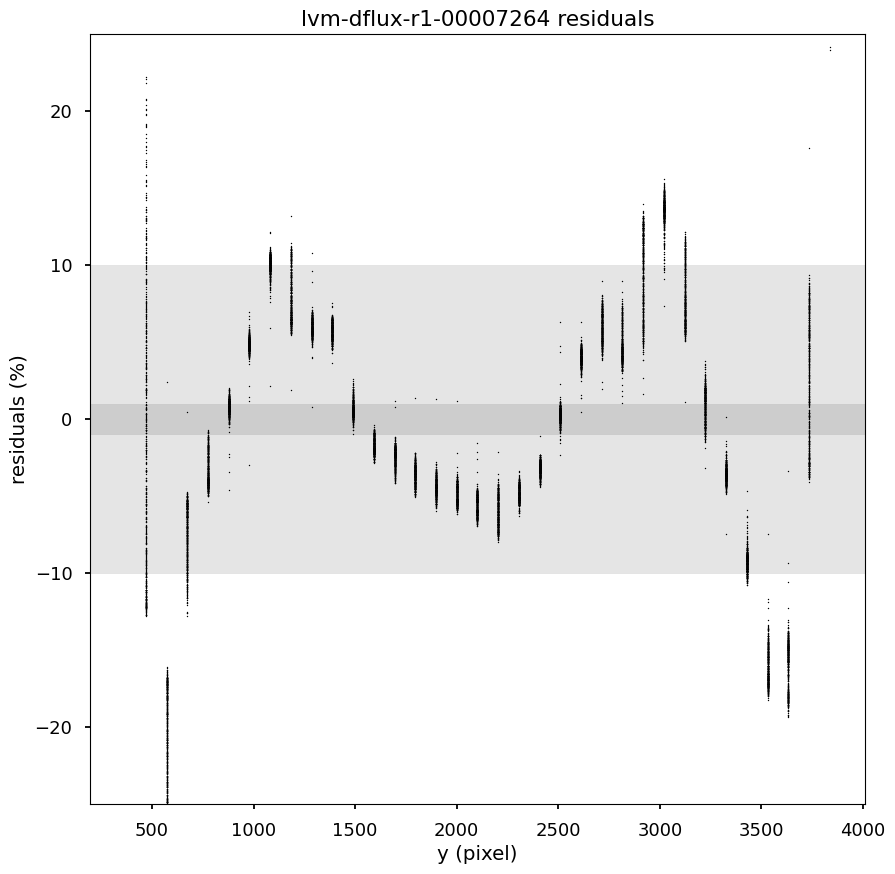

[INFO]: fitting centroid trace with 4-deg polynomial
[INFO]: writing trace data to files: lvm-dcent-r1-00007264_coords.txt, lvm-dcent-r1-00007264_poly.txt and lvm-dcent-r1-00007264_poly_all.txt


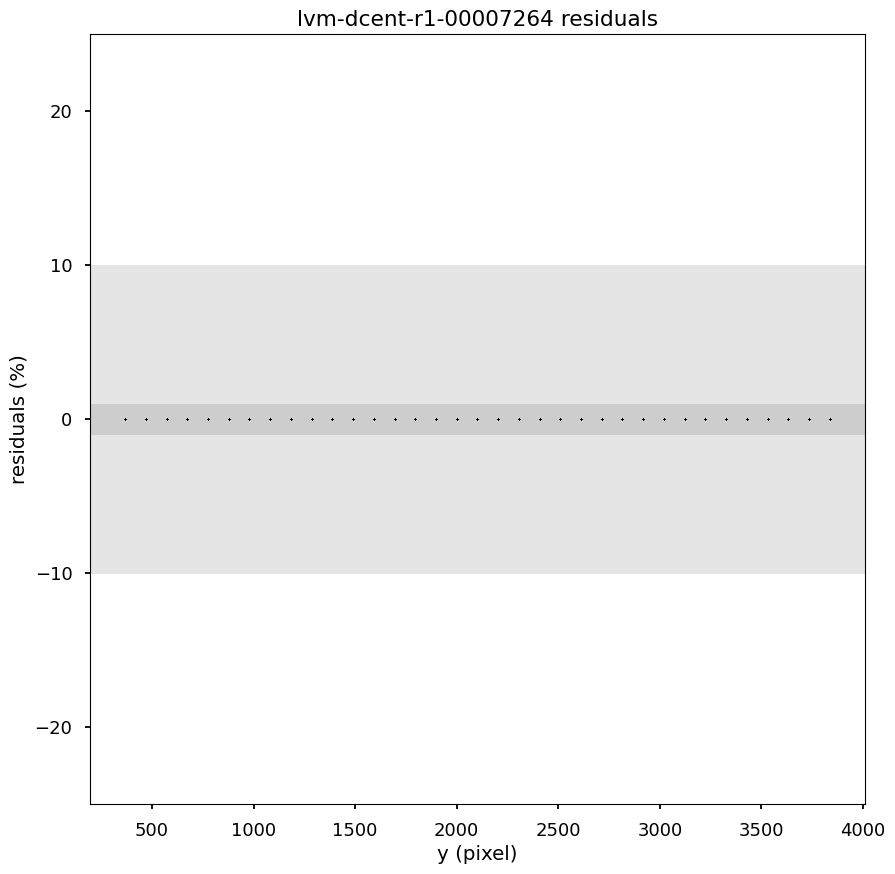

[INFO]: fitting FWHM trace with 5-deg polynomial
[INFO]: writing trace data to files: lvm-dfwhm-r1-00007264_coords.txt, lvm-dfwhm-r1-00007264_poly.txt and lvm-dfwhm-r1-00007264_poly_all.txt


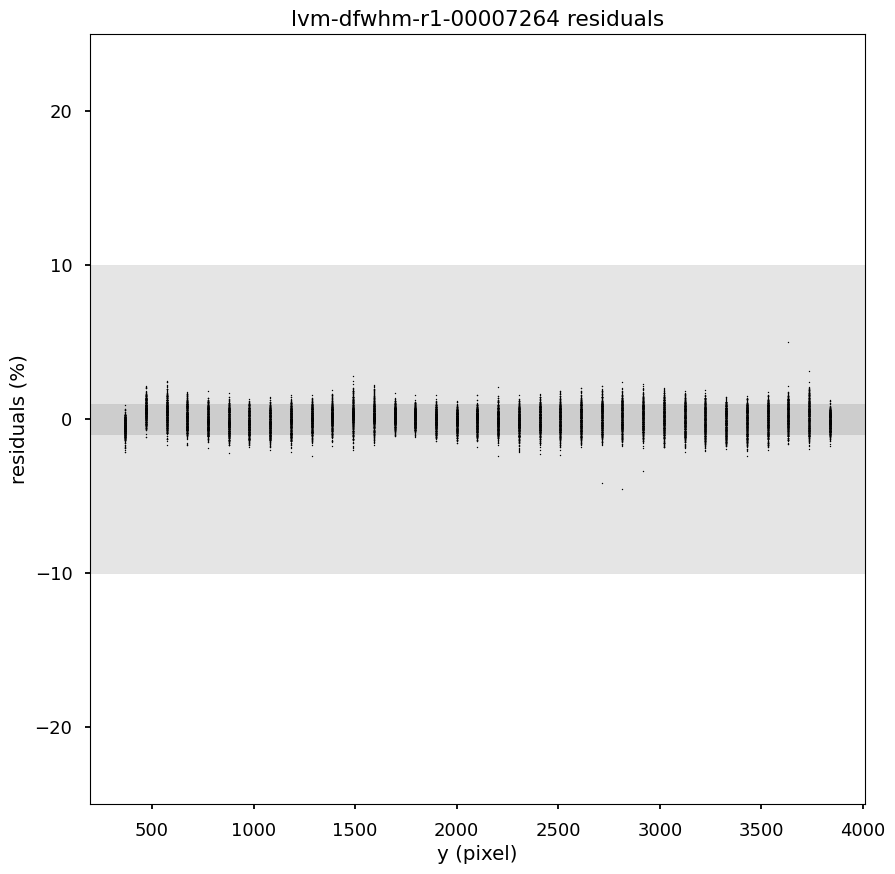

[INFO]: writing amplitude trace to 'lvm-dflux-r1-00007264.fits'
[INFO]: writing centroid trace to 'lvm-dcent-r1-00007264.fits'
[INFO]: writing FWHM trace to 'lvm-dfwhm-r1-00007264.fits'
[INFO]: plotting results


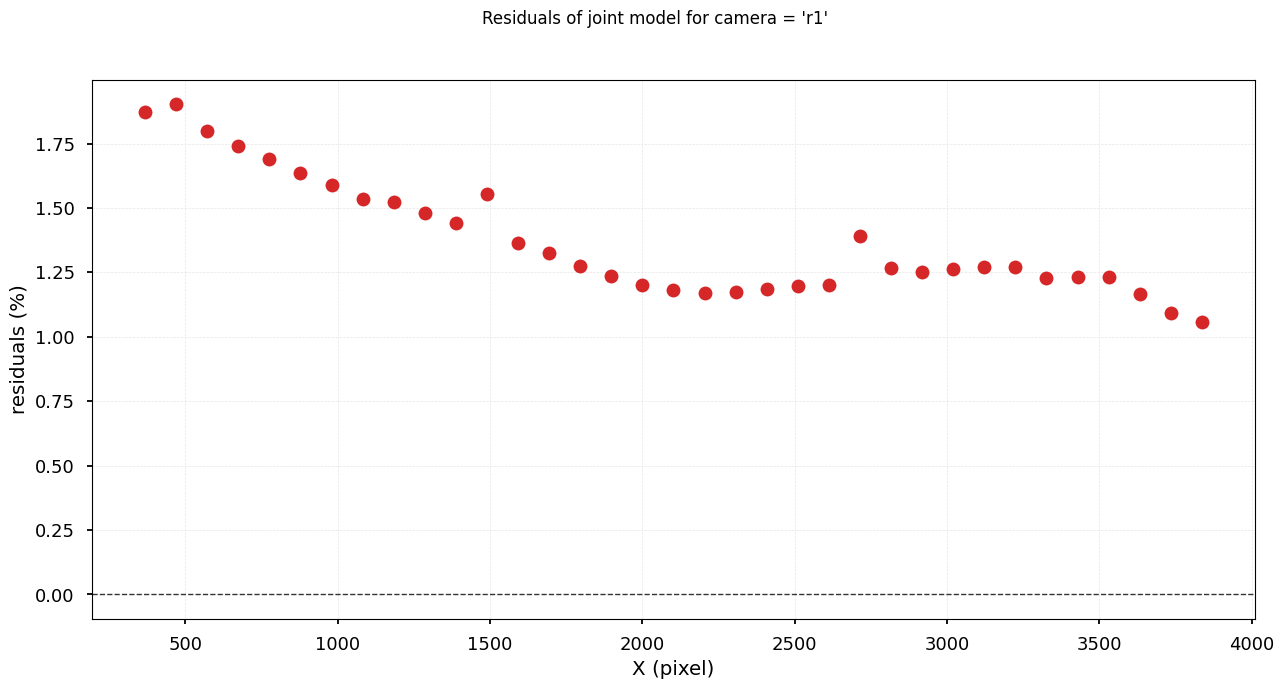

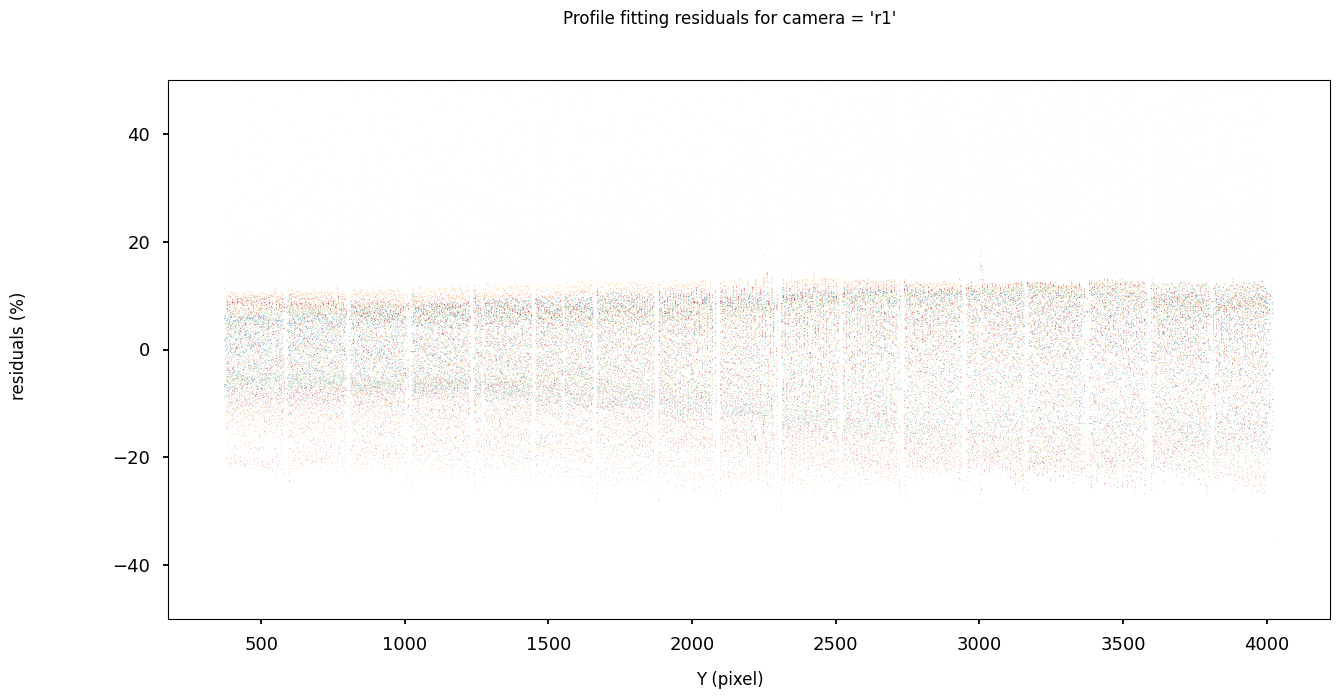

[INFO]: using flat image lvm-dflat-r1-00007267.fits for tracing


camera = 'r1', expnum = 7264, fiber_str =   P1-7, fiber_idx = 397, FWHM = 2.38
going to trace std fiber P1-10 in r1 within block_idxs = [17]


[INFO]: performing median filtering with box (1, 10) pixels
[INFO]: coadding 20 pixels along the dispersion axis
[INFO]: correcting guess positions for column 2000
[INFO]: stretch factor: 1.001, shift: -7.000
[INFO]: tracing centroids in 140 columns: 28,57,86,115,144,173,202,231,260,289,318,347,376,405,434,463,492,521,550,579,608,637,666,695,724,753,782,811,840,869,898,927,956,985,1014,1043,1072,1101,1130,1159,1188,1217,1246,1275,1304,1333,1362,1391,1420,1449,1478,1507,1536,1565,1594,1623,1652,1681,1710,1739,1768,1797,1826,1855,1884,1913,1942,1971,2000,2029,2058,2087,2116,2145,2174,2203,2232,2261,2290,2319,2348,2377,2406,2435,2464,2493,2522,2551,2580,2609,2638,2667,2696,2725,2754,2783,2812,2841,2870,2899,2928,2957,2986,3015,3044,3073,3102,3131,3160,3189,3218,3247,3276,3305,3334,3363,3392,3421,3450,3479,3508,3537,3566,3595,3624,3653,3682,3711,3740,3769,3798,3827,3856,3885,3914,3943,3972,4001,4030,4059
tracing centroids: 100%|##########| 141/141 [00:32<00:00,  4.34column/s]
[INFO]: fitti

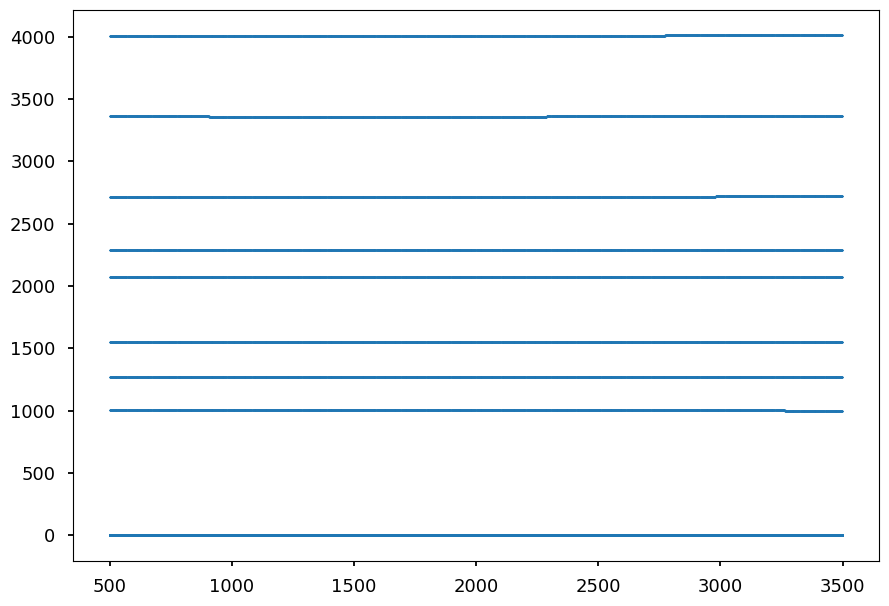

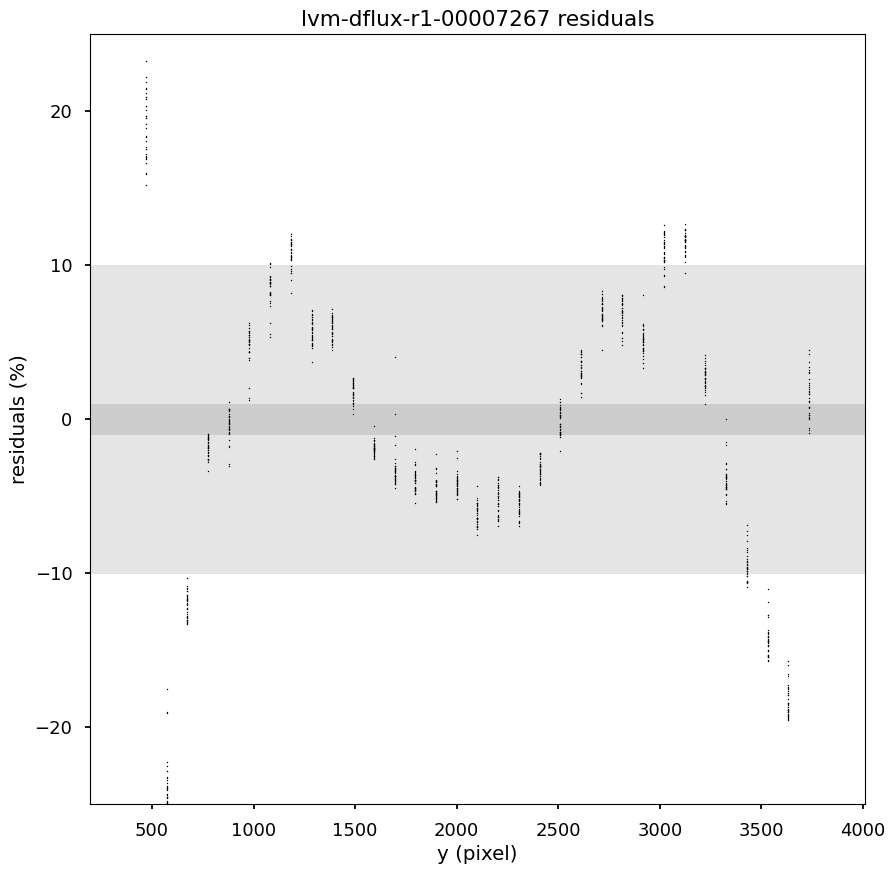

[INFO]: fitting centroid trace with 4-deg polynomial
[INFO]: writing trace data to files: lvm-dcent-r1-00007267_coords.txt, lvm-dcent-r1-00007267_poly.txt and lvm-dcent-r1-00007267_poly_all.txt


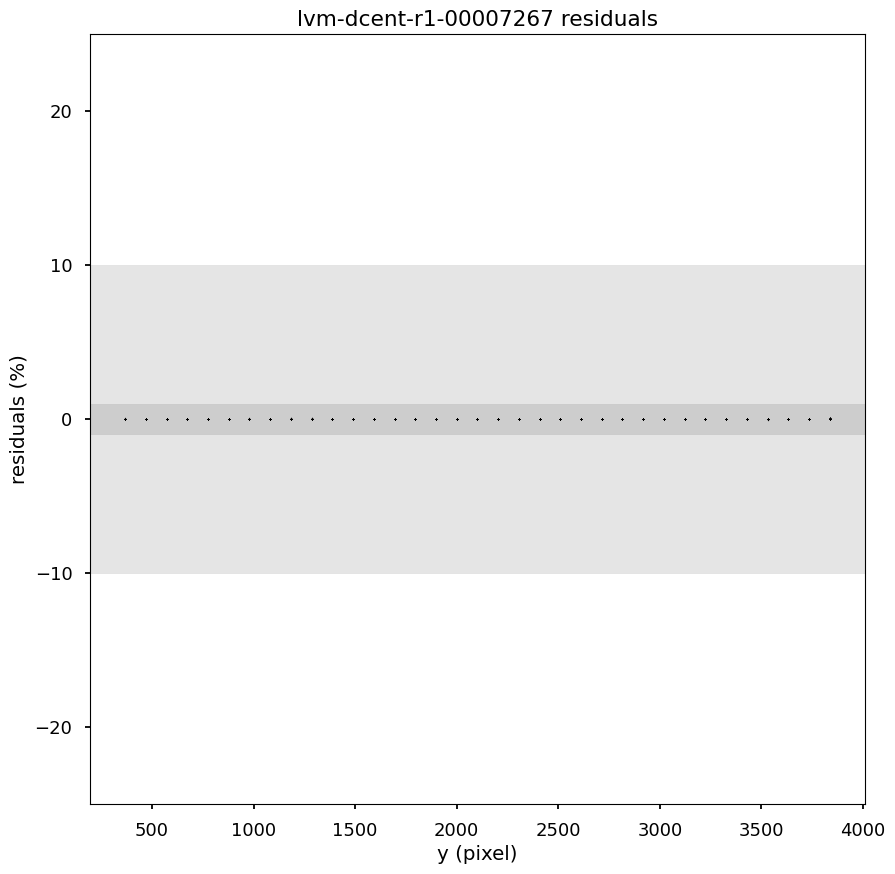

[INFO]: fitting FWHM trace with 5-deg polynomial
[INFO]: writing trace data to files: lvm-dfwhm-r1-00007267_coords.txt, lvm-dfwhm-r1-00007267_poly.txt and lvm-dfwhm-r1-00007267_poly_all.txt


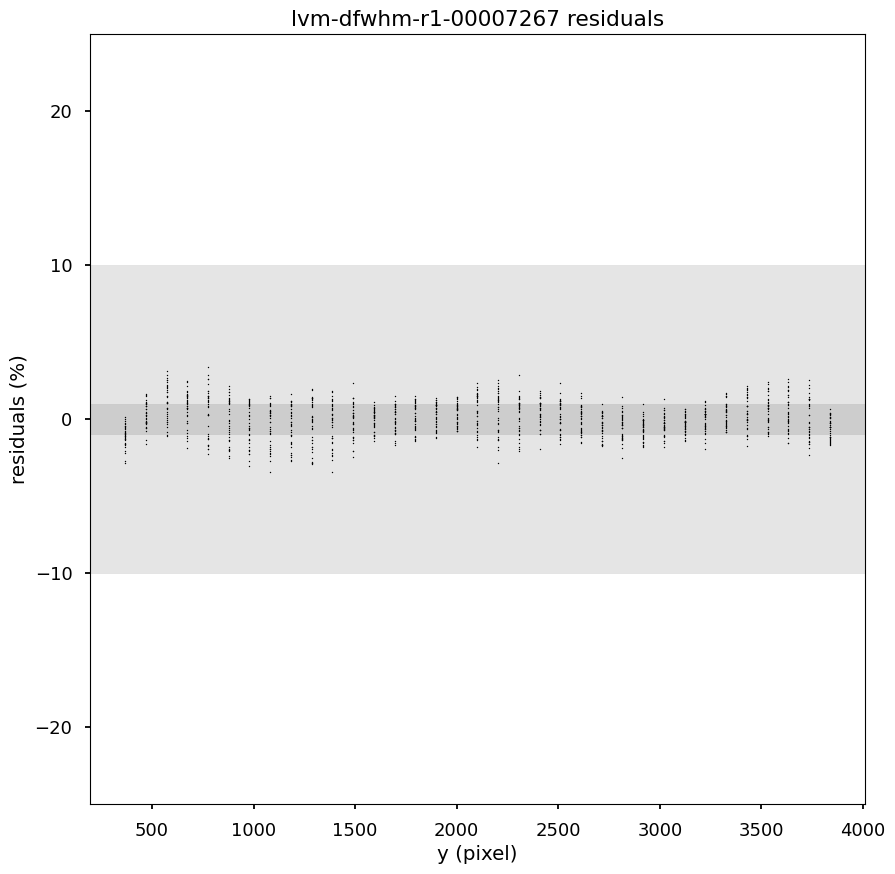

[INFO]: writing amplitude trace to 'lvm-dflux-r1-00007267.fits'
[INFO]: writing centroid trace to 'lvm-dcent-r1-00007267.fits'
[INFO]: writing FWHM trace to 'lvm-dfwhm-r1-00007267.fits'
[INFO]: plotting results


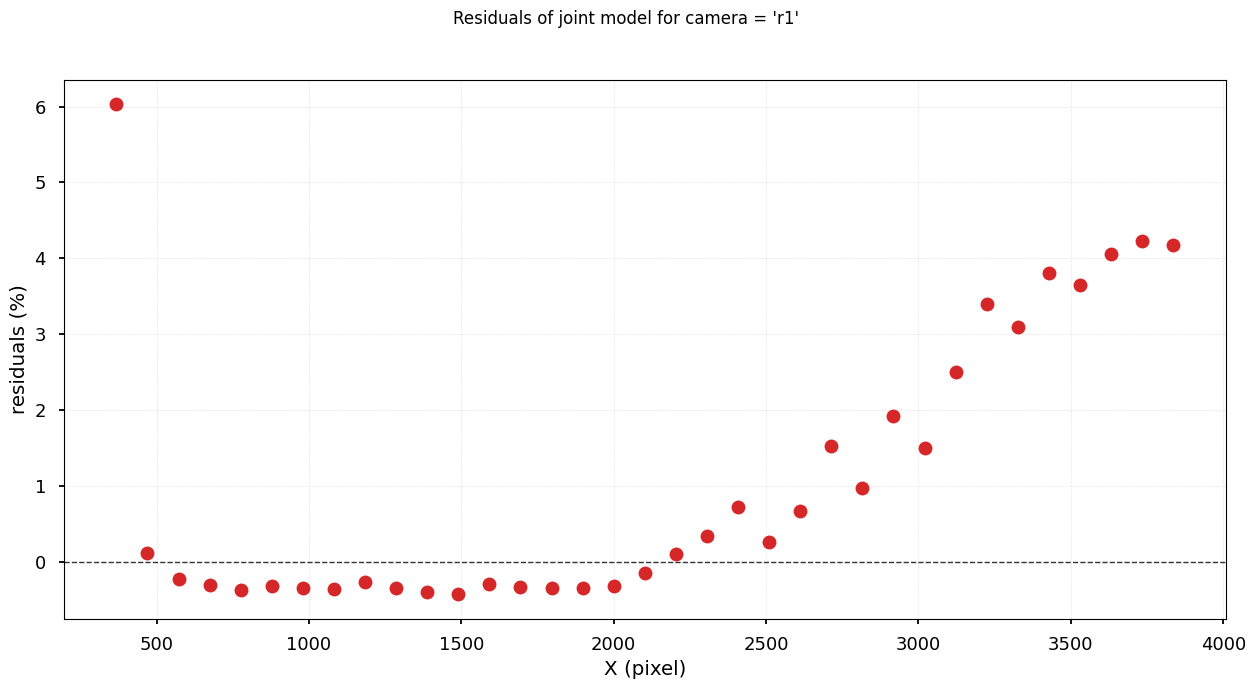

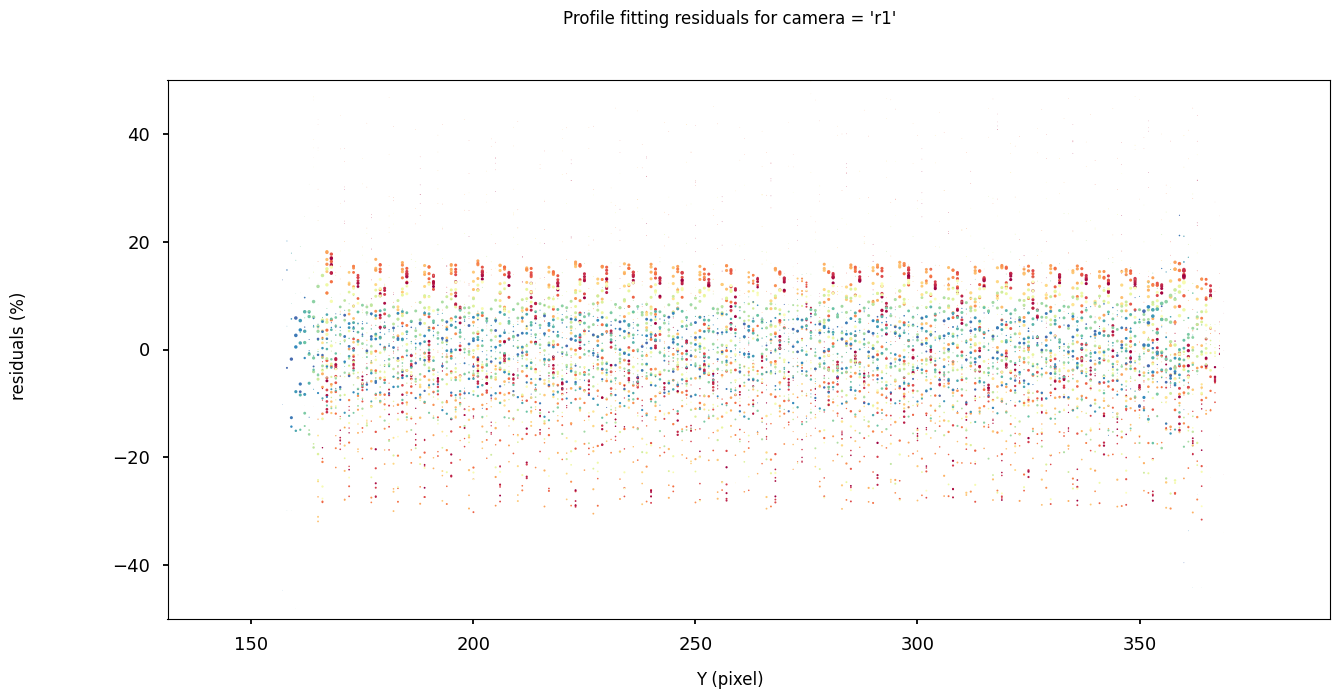

camera = 'r1', expnum = 7267, fiber_str =  P1-10, fiber_idx = 613, FWHM = 2.43


evaluating Gaussians: 100%|##########| 4086/4086 [03:52<00:00, 17.58column/s]


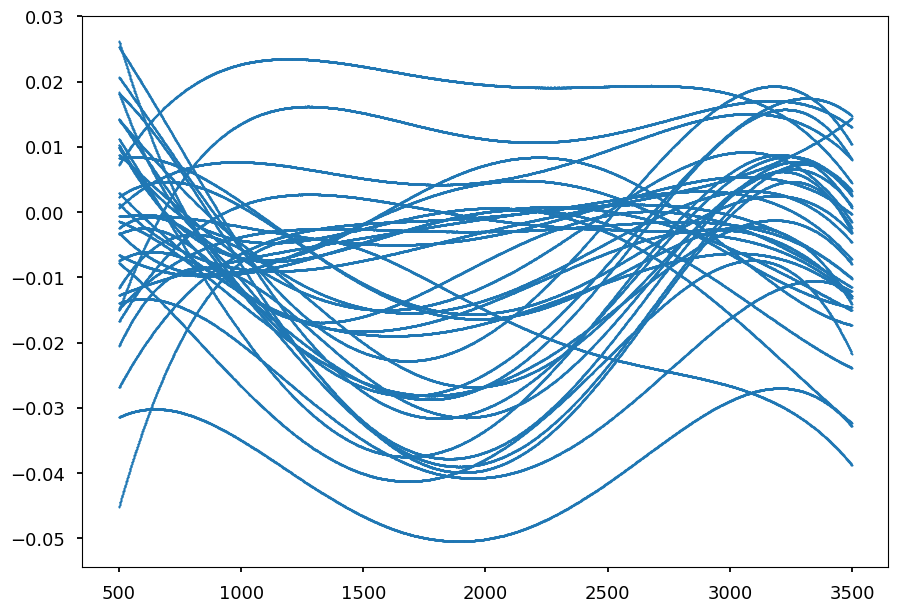

In [6]:
ldls_expnums = np.arange(7264, 7269+1)
ldls_expnums = [None] * (12-ldls_expnums.size) + ldls_expnums.tolist()
qrtz_expnums = np.arange(7252, 7263+1)

fit_poly = True
poly_deg_amp = 5
poly_deg_cent = 4
poly_deg_width = 5

# load current traces
mamps, mcents, mwidths = {}, {}, {}
for _ in product("brz", "123"):
    camera = "".join(_)
    mamps[camera] = TraceMask()
    mamps[camera].createEmpty(data_dim=(648, 4086), poly_deg=poly_deg_amp)
    mcents[camera] = TraceMask()
    mcents[camera].createEmpty(data_dim=(648, 4086), poly_deg=poly_deg_cent)
    mwidths[camera] = TraceMask()
    mwidths[camera].createEmpty(data_dim=(648, 4086), poly_deg=poly_deg_width)

# iterate through exposures with std fibers exposed
expnum_params = _get_ring_expnums(ldls_expnums, qrtz_expnums, ring_size=12)
for camera, expnums in expnum_params.items():
    if camera != "r1":
        continue
    for expnum, block_idxs, fiber_str in expnums:
        con_lamp = MASTER_CON_LAMPS[camera[0]]
        if con_lamp == "ldls":
            counts_threshold = 5000
        elif con_lamp == "quartz":
            counts_threshold = 10000

        # select fibers in current spectrograph
        fibermap = SLITMAP[SLITMAP["spectrographid"] == int(camera[1])]
        # select illuminated std fiber
        select = fibermap["orig_ifulabel"] == fiber_str
        # select fiber index
        fiber_idx = np.where(select)[0][0]

        # define paths
        dflat_path = path.full("lvm_anc", drpver=drpver, tileid=11111, mjd=MJD, kind="d", imagetype="flat", camera=camera, expnum=expnum)
        sflat_path = path.full("lvm_anc", drpver=drpver, tileid=11111, mjd=MJD, kind="s", imagetype="flat", camera=camera, expnum=expnum)
        flux_path = path.full("lvm_anc", drpver=drpver, tileid=11111, mjd=MJD, kind="d", imagetype="flux", camera=camera, expnum=expnum)
        cent_path = path.full("lvm_anc", drpver=drpver, tileid=11111, mjd=MJD, kind="d", imagetype="cent", camera=camera, expnum=expnum)
        fwhm_path = path.full("lvm_anc", drpver=drpver, tileid=11111, mjd=MJD, kind="d", imagetype="fwhm", camera=camera, expnum=expnum)
        model_path = path.full("lvm_anc", drpver=drpver, tileid=11111, mjd=MJD, kind="d", imagetype="model", camera=camera, expnum=expnum)
        mratio_path = path.full("lvm_anc", drpver=drpver, tileid=11111, mjd=MJD, kind="d", imagetype="mratio", camera=camera, expnum=expnum)

        # # trace only centroids
        # centroids, img = imageMethod.trace_fibers(
        #     in_image=dflat_path,
        #     out_trace_cent=cent_path,
        #     correct_ref=True, median_box=(1,10), coadd=20,
        #     counts_threshold=counts_threshold, max_diff=1.5,
        #     guess_fwhm=2.5, method="gauss", ncolumns=140,
        #     fit_poly=True, poly_deg=poly_deg_cent,
        #     interpolate_missing=True, only_centroids=True
        # )

        # # subtract stray light
        # imageMethod.subtract_straylight(
        #     in_image=dflat_path,
        #     out_image=sflat_path,
        #     in_cent_trace=cent_path,
        #     out_stray=f"test_stray-{camera}-{expnum:>08d}.fits",
        #     smooth_disp=11, aperture=5, poly_cross=9, smooth_gauss=10
        # )

        print(f"going to trace std fiber {fiber_str} in {camera} within {block_idxs = }")
        centroids, trace_cent_fit, trace_flux_fit, trace_fwhm_fit, img, model, mratio = imageMethod.trace_fibers(
            in_image=dflat_path,
            out_trace_amp=flux_path, out_trace_cent=cent_path, out_trace_fwhm=fwhm_path,
            out_trace_cent_guess=None,
            correct_ref=True, median_box=(1,10), coadd=20,
            counts_threshold=counts_threshold, max_diff=1.5, guess_fwhm=2.5, method="gauss",
            ncolumns=(140, 40), iblocks=block_idxs, fwhm_limits=(1.5, 4.5),
            fit_poly=fit_poly, interpolate_missing=False, poly_deg=(poly_deg_amp, poly_deg_cent, poly_deg_width), display_plots=True
        )

        # load traces
        print(f"{camera = }, {expnum = }, {fiber_str = :>6s}, fiber_idx = {fiber_idx:>3d}, FWHM = {trace_fwhm_fit._data[fiber_idx].mean():.2f}")

        # update master traces
        select_block = np.isin(fibermap["blockid"], [f"B{id+1}" for id in block_idxs])
        if fit_poly:
            mamps[camera]._coeffs[select_block] = trace_flux_fit._coeffs[select_block]
            mcents[camera]._coeffs[select_block] = trace_cent_fit._coeffs[select_block]
            mwidths[camera]._coeffs[select_block] = trace_fwhm_fit._coeffs[select_block]
        else:
            mamps[camera]._coeffs = None
            mcents[camera]._coeffs = None
            mwidths[camera]._coeffs = None
        mamps[camera]._data[select_block] = trace_flux_fit._data[select_block]
        mcents[camera]._data[select_block] = trace_cent_fit._data[select_block]
        mwidths[camera]._data[select_block] = trace_fwhm_fit._data[select_block]
        mamps[camera]._mask[select_block] = False
        mcents[camera]._mask[select_block] = False
        mwidths[camera]._mask[select_block] = False
        plt.scatter(np.repeat([np.arange(500,3500)], select_block.sum(), axis=0), centroids._data[select_block, 500:3500]-trace_cent_fit._data[select_block, 500:3500], s=1)

    # masking bad fibers
    bad_fibers = fibermap["fibstatus"] == 1
    mamps[camera]._mask[bad_fibers] = True
    mcents[camera]._mask[bad_fibers] = True
    mwidths[camera]._mask[bad_fibers] = True
    # masking untraced standard fibers
    fiber_strs = list(zip(*expnum_params[camera]))[2]
    untraced_fibers = np.isin(fibermap["orig_ifulabel"].value, list(set(fibermap[fibermap["telescope"] == "Spec"]["orig_ifulabel"])-set(fiber_strs)))
    mamps[camera]._mask[untraced_fibers] = True
    mcents[camera]._mask[untraced_fibers] = True
    mwidths[camera]._mask[untraced_fibers] = True

    # interpolate master traces in missing fibers
    if fit_poly:
        mamps[camera].interpolate_coeffs()
        mcents[camera].interpolate_coeffs()
        mwidths[camera].interpolate_coeffs()
    else:
        mamps[camera].interpolate_data(axis="Y", extrapolate=True)
        mcents[camera].interpolate_data(axis="Y", extrapolate=True)
        mwidths[camera].interpolate_data(axis="Y", extrapolate=True)

    # save master traces
    mamps[camera].writeFitsData(os.path.join(masters_path, f"lvm-mamps-{camera}.fits"))
    mcents[camera].writeFitsData(os.path.join(masters_path, f"lvm-mtrace-{camera}.fits"))
    mwidths[camera].writeFitsData(os.path.join(masters_path, f"lvm-mwidth-{camera}.fits"))

    # eval model continuum and ratio
    model, ratio = imageMethod._eval_continuum_model(img, mamps[camera], mcents[camera], mwidths[camera])
    model.writeFitsData(model_path)
    ratio.writeFitsData(mratio_path)

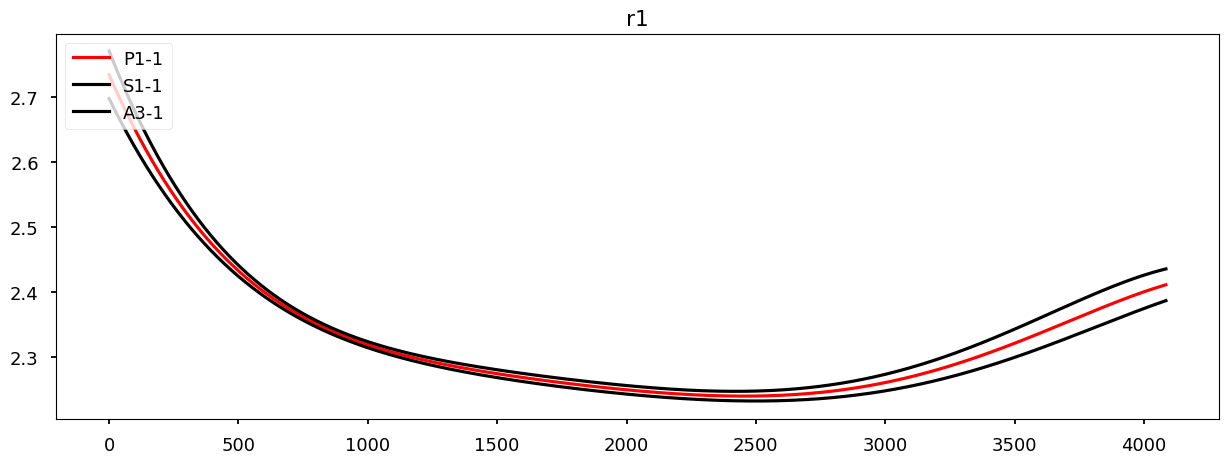

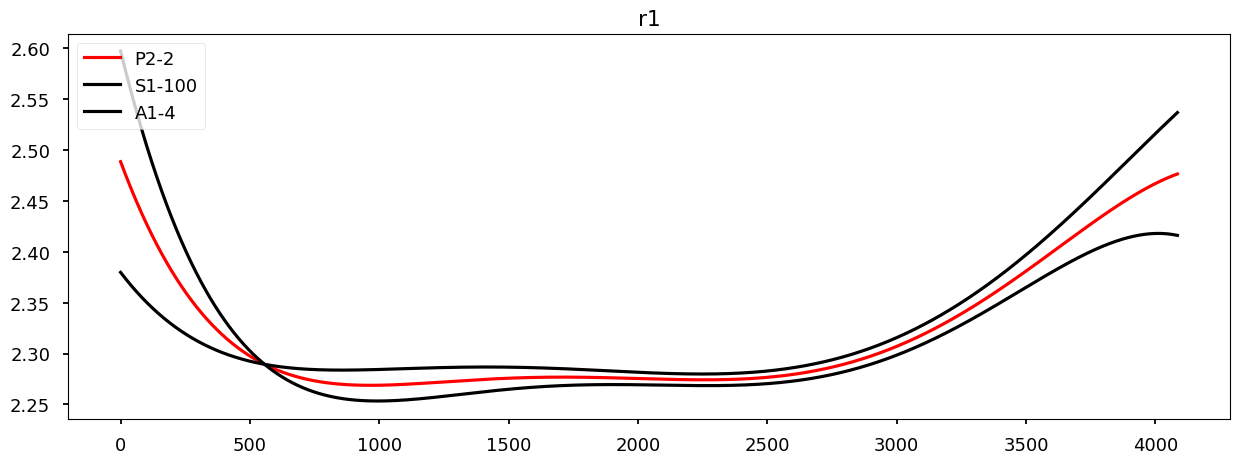

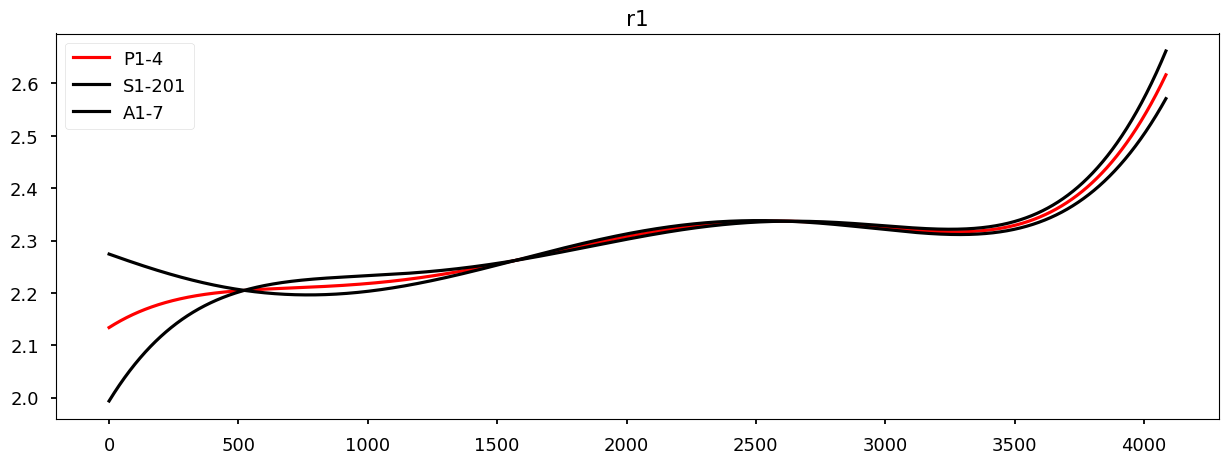

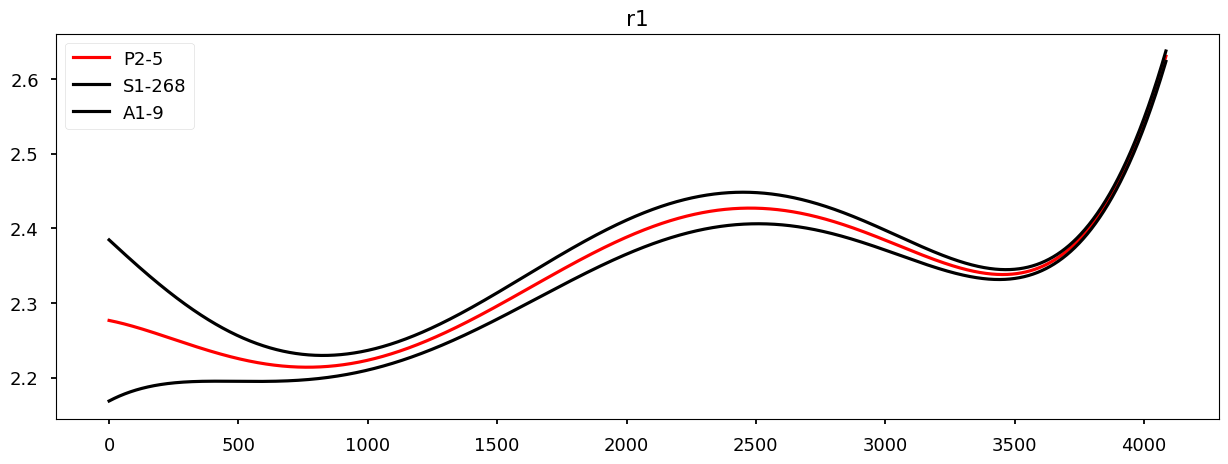

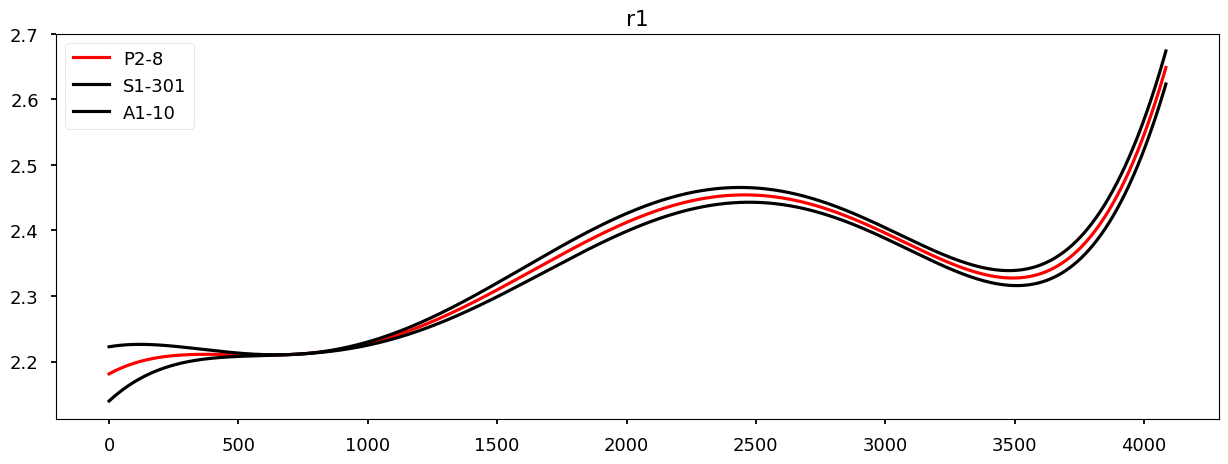

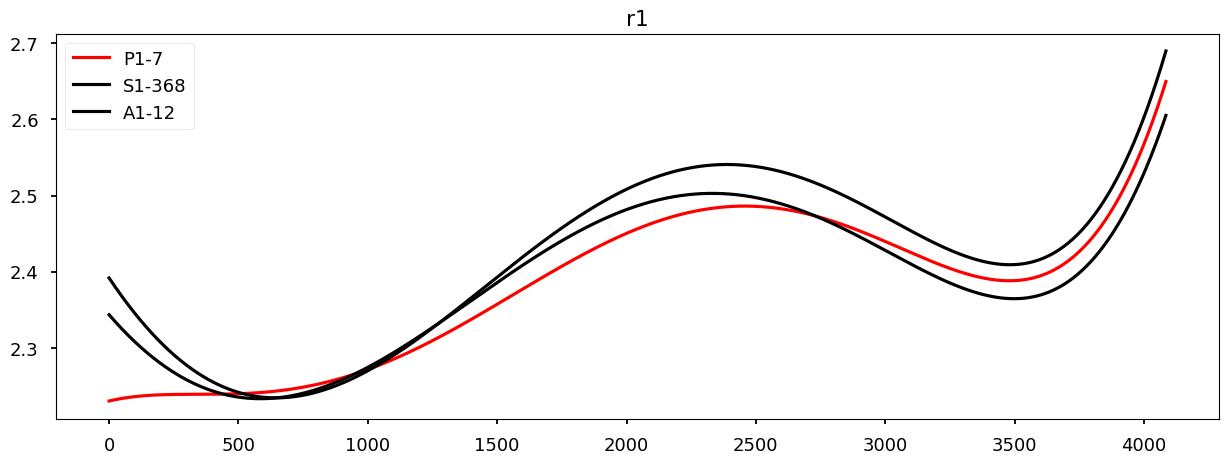

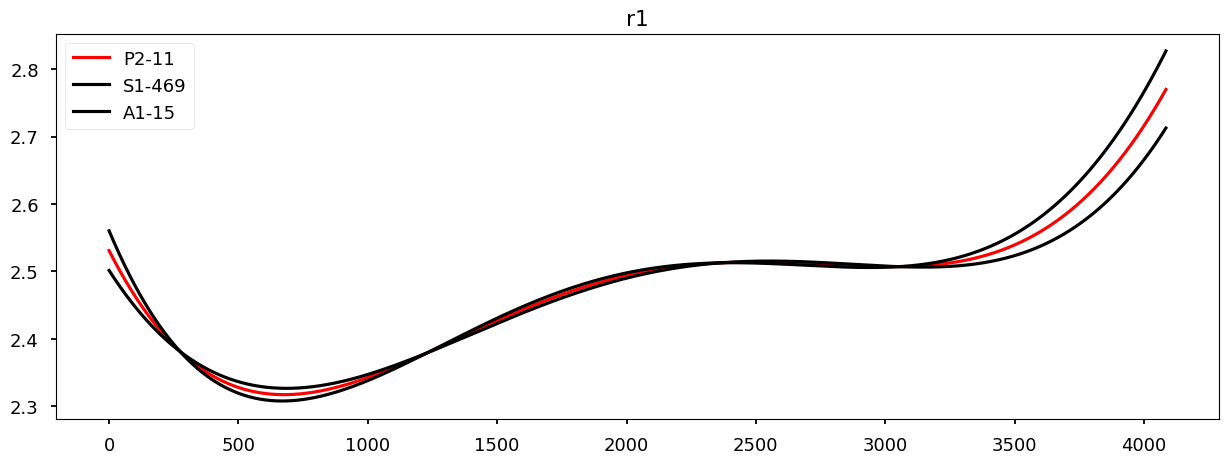

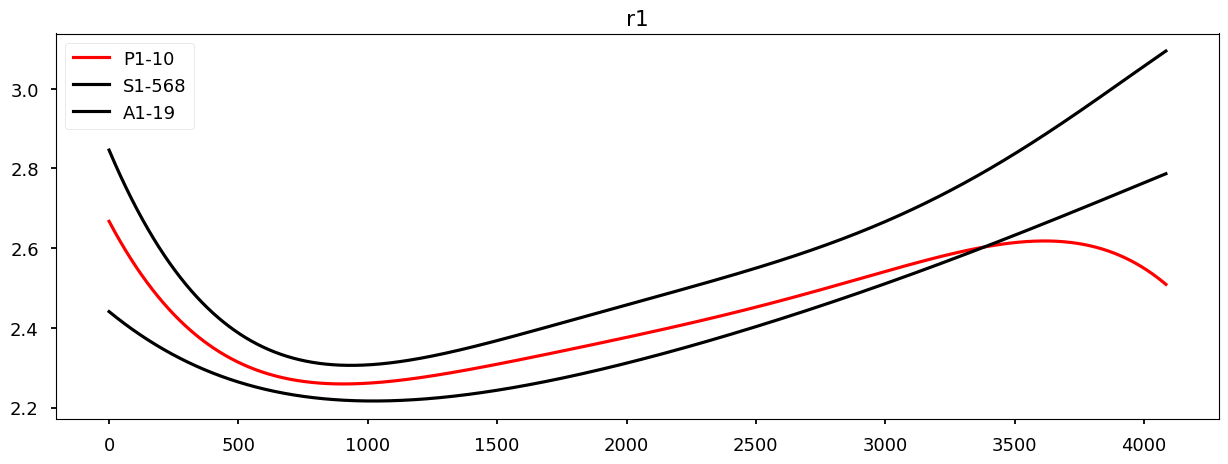

In [7]:
camera = "r1"
trace = copy(mwidths[camera])

fibermap = SLITMAP[SLITMAP["spectrographid"] == int(camera[1])]
select = fibermap["telescope"] == "Spec"
con_lamp = MASTER_CON_LAMPS[camera[0]]

ifibers = np.where(select)[0]
for idx in ifibers:
    plt.figure(figsize=(15, 5))
    plt.plot(trace._data[idx], color="r", label=fibermap[idx]["orig_ifulabel"])
    plt.plot(trace._data[idx+1], color="k", label=fibermap[idx+1]["orig_ifulabel"])
    plt.plot(trace._data[idx-1], color="k", label=fibermap[idx-1]["orig_ifulabel"])
    plt.title(f"{camera}")
    plt.legend(loc=2)

In [ ]:
# for camera in flat_analogs.groups:

#     con_lamp = MASTER_CON_LAMPS[camera[0]]
#     arc_lamp = MASTER_ARC_LAMPS[camera[0]]

#     mtrace_path = os.path.join(masters_path, f"lvm-mtrace-{camera}.fits")
#     mwidth_path = os.path.join(masters_path, f"lvm-mwidth-{camera}.fits")
#     mwave_path = os.path.join(masters_path, f"lvm-mwave_{arc_lamp}-{camera}.fits")
#     mlsf_path = os.path.join(masters_path, f"lvm-mlsf_{arc_lamp}-{camera}.fits")
#     # define master fiberflat path
#     mflat_path = path.full("lvm_master", drpver=drpver, tileid=1111, mjd=MJD, kind=f"mflat_{con_lamp}", camera=camera)
#     wflat_path = path.full("lvm_master", drpver=drpver, tileid=1111, mjd=MJD, kind=f"wmflat_{con_lamp}", camera=camera)

#     # if os.path.isfile(wflat_path):
#     #     print(f"skipping {wflat_path}, file already exist")
#     #     continue

#     # extract fiberflats
#     imageMethod.extract_spectra(in_image=mflat_path, out_rss=wflat_path, in_trace=mtrace_path, in_fwhm=mwidth_path, method="optimal", parallel=4)

#     # apply correction factor for the std fibers
#     fibermap = SLITMAP[SLITMAP["spectrographid"] == int(camera[1])]
#     select = fibermap["telescope"] == "Spec"
#     flat = rssMethod.loadRSS(wflat_path)
#     flat._data[select] = flat._data[select] * 24
#     flat._error[select] = flat._error[select] * 24
#     flat.writeFitsData(wflat_path)

#     rssMethod.create_pixel_table(in_rss=wflat_path, out_rss=wflat_path, arc_wave=mwave_path, arc_fwhm=mlsf_path)

In [ ]:
# for camera in flat_analogs.groups.keys():
#     fibermap = SLITMAP[SLITMAP["spectrographid"] == int(camera[1])]
#     select = fibermap["telescope"] == "Spec"
#     con_lamp = MASTER_CON_LAMPS[camera[0]]

#     mtrace_path = os.path.join(masters_path, f"lvm-mtrace-{camera}.fits")
#     trace = TraceMask()
#     trace.loadFitsData(mtrace_path)
#     trace._data[select]

#     plt.figure(figsize=(10, 5))
#     idx = np.where(select)[0]
#     plt.plot(trace._data[idx][0], color="r")
#     plt.plot(trace._data[idx+1][0], color="k")
#     plt.plot(trace._data[idx-1][0], color="k")
#     plt.title(f"{camera}")

#     wflat_path = path.full("lvm_master", drpver=drpver, tileid=1111, mjd=MJD, kind=f"wmflat_{con_lamp}", camera=camera)
#     flat = rssMethod.loadRSS(wflat_path)
#     flat._data[flat._mask] = np.nan

#     plt.figure(figsize=(10, 5))
#     plt.plot(flat._wave[select].T, flat._data[select].T, label="std")
#     plt.title(f"{camera}")

In [ ]:
# idx = 1

# flat = rssMethod.loadRSS(mfiberflat_paths[idx])
# print(mfiberflat_paths[idx])

# fibermap = SLITMAP[SLITMAP["spectrographid"] == 1]
# select = fibermap["telescope"] == "Spec"
# print(fibermap[select])
# plt.plot(flat._wave[~select][:12].T, flat._data[~select][:12].T)
# plt.plot(flat._wave[select].T, flat._data[select].T, "-k")